# Just Draft Notebook to prepare data from different datasets to one view.

In [1]:
%cd ..

/home/yurii_kharabara/ml_project/ML_Project


/home/yurii_kharabara/miniconda3/envs/cv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
import json
from PIL import Image
import pandas as pd

def find_leaf_nodes(node, leaf_nodes):
    if 'children' not in node or not node['children']:
        leaf_nodes.append(node)
    else:
        for child in node['children']:
            find_leaf_nodes(child, leaf_nodes)

def process_images_and_jsons(input_dir, output_dir, csv_filename):
    os.makedirs(output_dir, exist_ok=True)
    images_info = []
    image_id = 1

    for root, dirs, files in os.walk(input_dir):
        json_files = [file for file in files if file.endswith('.json')]
        image_files = [file for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]

        for json_file in json_files:
            json_path = os.path.join(root, json_file)
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            for image_file in image_files:
                image_path = os.path.join(root, image_file)
                try:
                    image = Image.open(image_path)
                    leaf_nodes = []
                    find_leaf_nodes(data, leaf_nodes)

                    for node in leaf_nodes:
                        if 'bbox' in node:
                            bbox = node['bbox']
                            role = node.get('role', 'Unknown')
                            cropped_image = image.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
                            if cropped_image.mode == 'RGBA':
                                cropped_image = cropped_image.convert('RGB')
                            new_image_name = f'image_{image_id}.jpg'
                            cropped_image.save(os.path.join(output_dir, new_image_name))
                            images_info.append({'image': new_image_name, 'label': role})
                            image_id += 1
                except Exception as e:
                    print(f"Error processing {image_file} with {json_file}: {e}")

    df = pd.DataFrame(images_info)
    df.to_csv(os.path.join(output_dir, csv_filename), index=False)

input_dir = 'data/MAC/test'
output_dir = 'data/MAC_Classification/validation'
csv_filename = 'labels.csv'
process_images_and_jsons(input_dir, output_dir, csv_filename)


Error processing Reminders-1707082155.34.png with com.apple.reminders.json: cannot write empty image as JPEG
Error processing Safari-1707176429.48.png with com.apple.Safari.json: cannot write empty image as JPEG
Error processing Due-1707213313.08.png with com.dueapps.duemac-setapp.json: cannot write empty image as JPEG
Error processing Google Chrome-1707230332.39.png with com.google.Chrome.json: cannot write empty image as JPEG
Error processing IconJar-1707170614.26.png with com.iconjar.iconjar-setapp.json: cannot write empty image as JPEG
Error processing Typing Mind-1707209808.56.png with com.devuap.Typing-Mind-setapp.json: cannot write empty image as JPEG
Error processing News Explorer-1707239727.03.png with com.betamagic.News-Explorer-setapp.json: cannot write empty image as JPEG
Error processing App Store-1707174111.80.png with com.apple.AppStore.json: 'NoneType' object is not subscriptable
Error processing -1707239034.13.png with com.chekazuja.keykey-setapp.json: cannot write emp

In [4]:
with open('data/MAC_Classification/train/labels.csv', 'r') as file:
    print(file.readlines()[-1])

image_8260.jpg,AXStaticText



In [11]:
import pandas as pd

def filter_classes_in_csv(input_csv, output_csv, classes_to_keep):
    df = pd.read_csv(input_csv)
    filtered_df = df[df['label'].isin(classes_to_keep)]
    
    filtered_df.to_csv(output_csv, index=False)
    print(f"Filtered CSV saved. Kept {len(filtered_df)} entries out of {len(df)}.")

classes_to_keep = ['AXStaticText', 'AXButton', 'AXImage']

input_csv = 'data/MAC_Classification/validation/labels.csv'  # Adjust this path to your initial CSV file location
output_csv = 'data/MAC_Classification/validation/filtered_labels.csv'  # Path where the filtered CSV will be saved
filter_classes_in_csv(input_csv, output_csv, classes_to_keep)


Filtered CSV saved. Kept 1987 entries out of 2339.


In [10]:
annotations = pd.read_csv('data/MAC_Classification/train/filtered_labels.csv')
unique_labels = annotations.iloc[:, 1].unique()
unique_labels = unique_labels.tolist()
unique_labels.sort()
unique_labels

['AXButton', 'AXImage', 'AXStaticText']

In [13]:
annotations = pd.read_csv('data/MAC_Classification/validation/filtered_labels.csv')
unique_labels = annotations.iloc[:, 1].unique()

unique_labels = unique_labels.tolist()
unique_labels.sort()
unique_labels

['AXButton', 'AXImage', 'AXStaticText']

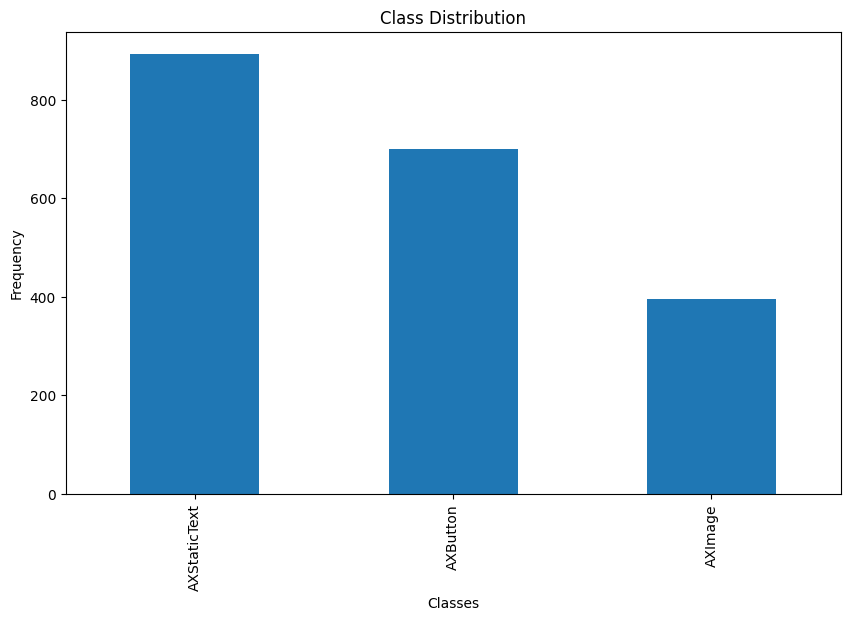

label
AXStaticText    893
AXButton        699
AXImage         395
Name: count, dtype: int64


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def check_class_balance(csv_file):
    data = pd.read_csv(csv_file)
    class_counts = data['label'].value_counts()

    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show()

    return class_counts

class_counts = check_class_balance('data/MAC_Classification/validation/filtered_labels.csv')
print(class_counts)


label
button    1929
image     1929
text      1929
link      1929
field     1929
Name: count, dtype: int64


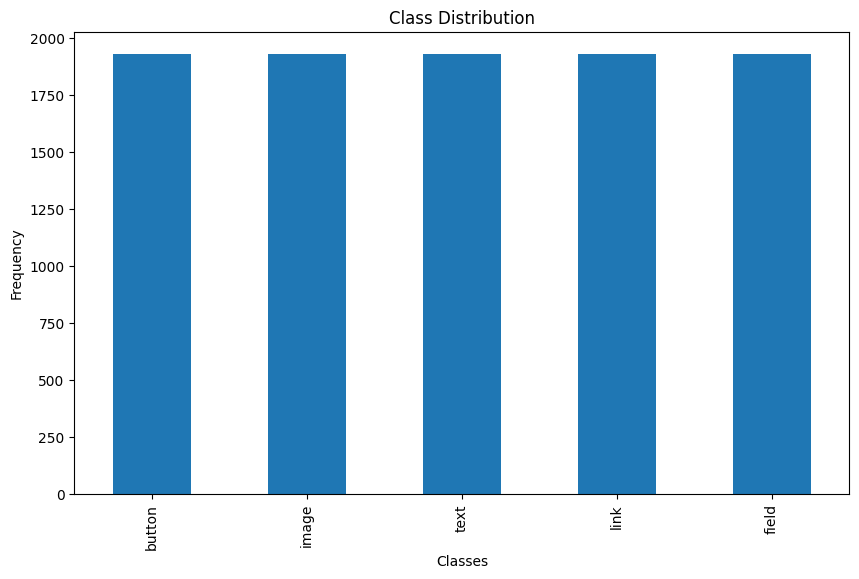

label
button    1929
image     1929
text      1929
link      1929
field     1929
Name: count, dtype: int64


In [51]:
import pandas as pd
from sklearn.utils import resample

def balance_dataset_halfway(csv_file, output_csv_file):
    data = pd.read_csv(csv_file)
    class_counts = data['label'].value_counts()
    target_size = (class_counts.max() + class_counts.min()) // 2  # Target size is the average of max and min class sizes

    resampled_list = []
    
    for label, group in data.groupby('label'):
        if len(group) > target_size:
            resampled_group = resample(group, replace=False, n_samples=target_size, random_state=123)
        else:
            resampled_group = resample(group, replace=True, n_samples=target_size, random_state=123)
        resampled_list.append(resampled_group)

    balanced_data = pd.concat(resampled_list)
    
    # Shuffle 
    balanced_data = balanced_data.sample(frac=1, random_state=123).reset_index(drop=True)
    
    balanced_data.to_csv(output_csv_file, index=False)

    return balanced_data

balanced_data = balance_dataset_halfway('data/roboflow_classification/valid/filtered_labels.csv', 'data/roboflow_classification/valid/_balanced_labels.csv')
print(balanced_data['label'].value_counts())
class_counts = check_class_balance('data/roboflow_classification/valid/_balanced_labels.csv')
print(class_counts)